<a href="https://colab.research.google.com/jessegrabowski/spartan-stats-tutomrial-2025/blob/main/notebooks/01_intro_to_pymc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**💡 To better engage gray mass we suggest you turn off Colab AI autocompletion in `Tools > Settings > AI Assistance`**

In [1]:
import matplotlib.pyplot as plt
import numpy as np


# Set a random seed for reproducibility
seed = sum(map(ord, 'Spartan Intro to PPL'))
rng = np.random.default_rng(seed)

# A (Fast!) Introduction to a PPL

A Probabilistic Programming Language (PPL) is a peice of software that allows you to write programs that work with random inputs and outputs.

It is perhaps not obvious why anyone would want to do this, so some preable is required.

## Different Types of Data

The prupose of statisticals is to tease out patterns from observed data.

Well, that's not entirely true. Sometimes you want to tease out patterns from data, and other times you want to impose patterns on the data. Which regime you find yourself in depends a lot on your data! When the data are relatively easy to gather, you can rely on a "purely" statistical model to learn patterns. The ne plus ultra example is LLMs, which use extremely flexible frameworks (e.g. transforms) to learn nuanced statistical patterns from largely static data.

On the other hand, once you leave the cozy world of iid data, things become a lot more difficult. Data might be low quality or imprecisely measured, leading statistical models to overfit (finance, polling). Or we might be unable to ever resample the data (sports matches, elections), and we have to try to tease out similarities from fundimentally different things. 

[Michael Betancourt](https://www.youtube.com/watch?v=jUSZboSq1zg) likes to show a graph that looks like the following. In the "wide data" regime, we are able to resample high-quality data as required, and machine learning techinques work great. In the "tall data" regime, __the act of collecting more data necessarily introduces more complexity into the sample__. To work in the tall data regime, we need to bring some structure to bear.

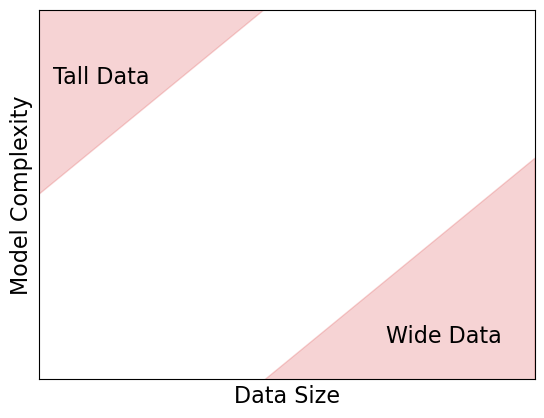

In [2]:
fig, ax = plt.subplots()
xlims, ylims = ax.get_xlim(), ax.get_ylim()
x_grid = np.linspace(0, 1, 100)
lower_line = -0.5 + 1.1 * x_grid
upper_line = 0.5 + 1.1 * x_grid

ax.fill_between(x_grid, 0, lower_line, alpha=0.2, color='tab:red')
ax.fill_between(x_grid, upper_line, 10, alpha=0.2, color='tab:red')

ax.text(0.7, 0.1, 'Wide Data', fontdict={'size':16})
ax.text(0.03, 0.8, 'Tall Data', fontdict={'size':16})

ax.set(xlim=xlims, ylim=ylims)
ax.set_xlabel('Data Size', size=16)
ax.set_ylabel('Model Complexity', size=16)

ax.tick_params(axis='both', which='both', tick1On=False, label1On=False)

## Causality and Interpretability

Another reason to care about a PPL is for causal interpretability and causal inference.

A major limitation to the "wide data" regime is how to make sense of the outputs. Many researchers make their whole careers on trying to figure out, for example, exactly *where* in the weights of a transformer-based LLM a certain decision rule "lives". An evocative example of this type of research is the [OpenAI microscope](https://distill.pub/2017/feature-visualization/) (Yannic Kilcher [video](https://www.youtube.com/watch?v=Ok44otx90D4)). 

In many other cases, especially in the sciences, it's not sufficent to have an arbitrary model that makes good predictions. Researchers what to uncover *causal linkages* between observed phenomena, which requires control over the proposed functional forms used in estimation. This rules out, *a priori*, many machine learning techniques that don't admit a clean notion of "feature importantance". Resources on this topic include the writings of [Jueda Pearl](https://en.wikipedia.org/wiki/Judea_Pearl) ([The Book of Why](https://www.amazon.com/Book-Why-Science-Cause-Effect/dp/046509760X) is a nice pop-science introduction), and Richard McElreath's textbook [Statistical Rethinking](https://www.taylorfrancis.com/books/mono/10.1201/9780429029608/statistical-rethinking-richard-mcelreath) (and associated [YouTube lecture series](https://www.youtube.com/playlist?list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus) ).

## Estimating Structure

So say you collect data. Maybe you just don't have that much data, but you know from the science that there should be a lot of structure. Or, maybe you can collect a ton of data, but it's extremely heterogeneous: each observation comes from a different sub-population, like observing economic data from different countries over time. Again, from the science, you know that there are similarities, but these are swamped out by the differences.

In either case, you're not going to be able to just take your data as-is and shove it into XGBoost. You now have several choices:

### 1. Give up and go simple

It might be the case that the model you *want* to fit is just not possible, given the estimators you have at your disposal. So you fit some kind of linear approximation to the true model, and add a section to your research explaining that you know you should have done something else, but this is a good first effort and establishes a lower/upper bound on the effect of interest, in a certain special case.

### 2. Hit it with a hammer

By this, I mean find a way to reformat your data to make it fit the estimator you want to work with. In econometrics, this is a common approach. You have an estimator that everyone uses (OLS), and you need to make your data fit that estimator. This might mean doing data transformations, feature engineering, dropping outliers, and the like. 

### 3. Derive a new estimator

This might mean a specialized standard error formula, or it might mean pages of linear algebra, proving that in your special case, results will be unbiased. Again, in econometrics, people come up with new estimators every day or specialized situations. You have estimators for heterogeneous cross-sectional data (fGLS), estimators for panel data (within, between, first-difference), estimators for dynamic panels (arnello-bond), estimators for gravity models of trade data (Poisson pseudo-likelihood regression with multiple levels of fixed effects (ppmlhdfe)), and on and on and on...

### 4. Just use a PPL!

Or, you can just use a PPL. In general, this is going to imply that you are going the Bayesian route. Bayes has only one estimator: the posterior distribution. In this paradim, you exchange difficulty in the modeling step (how do I encode all the structure I want into the problem), with difficulty in the inference step (how do I actually obtain results). 

# So what is a PPL anyway?

The point of a PPL is that you can write down arbitrarility complex models, inserting random variables all over the place, and the software will handle the propogation of randomness.

## Definition: Generative Model

To write our first probabilistic program, we need to write down a *statistical model*. It's not obvious how to do this at first blush. The approach I advocate for (and the approach that PyMC pushes you towards) is to think of your data as resulting from a *generative process*.

You might be familar with generative models in the context of deep learning. LLMs and image generation models are generative models, because their output is new data that looks like the training set. The difference between generative and non-generative models is important! OLS, for example, cannot generate new data. It can make predictions, but once fit, these predictions are *deterministic* -- you will always get the same value for the same inputs. By contrast, feeding the same initial noise state and conditioning text into Stable Diffusion will generate a different picture each time. 

Having access to a generative model is useful, because it allows you to check whether your model generates data that looks like the data we observe, and which matches with our theory-informed intuitions. 

In a PPL, **all** models are generative. We use theory to write down a generative process, then *sample* from the model to check that everything makes sense.

### Example: Stock Prices

A simple first example is the evolution of stock prices. Per Eugene Fama, markets are "efficient", which implies that current market prices encode all available information about a company, the economy, and so on. Call this set of all information $\mathcal{D}$ for "data". If markets are efficient, this information is useless, and the best forecast of future stock prices is just the current stock price:

$$ \mathbb E[P_{t+1} | \mathcal{D}] = P_t $$

A model where the best guess of tomorrow comes up enough that it has a special name: a **Random Walk**. Obviously prices tomorrow aren't likely to be prices today -- that's only in expectation. We want to include some *random noise*, $\epsilon_t$. Our model will be:

$$ P_{t} = P_{t-1} + \epsilon_{t} $$

To proceed, we need to make assumptions about $\epsilon_t$. Let's suppose it's normally distributed, so that:

$$ \epsilon_t \sim N(0, \sigma) $$

This implies that $P_t$ itself is normally distributed:

$$ P_t \sim N(P_{t-1}, \sigma) $$

We don't observe $\sigma$, so we will have to make some assumptions about that as well. Since it's a standard deviation, it needs to be strictly positive. We don't have any theory to guide us, so let's just say it follows a Half Normal distribution, which is just a normal chopped in half at zero. 

Actually none of this is very helpful. Let's say I have a $\sigma$, but I still don't have a $P_{t-1}$. How can I get $P_t$? To cut this Gordion knot, let's make a random $P_0$. Prices are strictly positive, so we can also draw that from a HalfNormal. With $P_0$ in hand, we can generate $P_1 = P_0 + \epsilon_1$, then $P_2 = P_1 + \epsilon_2$, and so on.

The eagle eyed among you will notice that we can do some rewriting here. Let's look again. Here are the first 3 prices in our model:

$$
\begin{align}
P_1 & = P_0 + \epsilon_1 \\
P_2 & = P_1 + \epsilon_2 \\
P_3 & = P_2 + \epsilon_3 
\end{align}
$$

But we have an equation for $P_1$, so plug it into the equation for $P_2$ :

$$
\begin{align}
P_1 & = P_0 + \epsilon_1 \\
P_2 & = P_0 + \epsilon_1 + \epsilon_2 \\
P_3 & = P_2 + \epsilon_3 
\end{align}
$$

And plug in the equation for $P_2$ into $P_3$:

$$
\begin{align}
P_1 & = P_0 + \epsilon_1 \\
P_2 & = P_0 + \epsilon_1 + \epsilon_2 \\
P_3 & = P_0 + \epsilon_1 + \epsilon_2 + \epsilon_3 
\end{align}
$$

We see that value of $P_t$ will just be $P_0$, plus the sum of all the random innovations up to $t$!

$$ P_t = P_0 + \sum_{s=1}^t \epsilon_{s} $$

So our first model will be as follows:

$$
\begin{align}
P_t &= P_0 + \sum_{s=1}^t \epsilon_{s} \\
P_0 & \sim \text{HalfNormal}(1) \\
\epsilon_s & \sim N(0, \sigma) \\
\sigma & \sim \text{HalfNormal}(1)
\end{align}
$$

In [3]:
import pymc as pm
T = 100 # Total timesteps to simulate

with pm.Model(coords={'time':range(T)}) as stock_model:
    # Convert the math formulas to code!
    P0 = pm.HalfNormal('P0', 1)
    sigma = pm.HalfNormal('sigma', 1)

    # CustomDist is a special distribution that lets PyMC work out the distribution associated with arbitrary math.
    # We do this because we want to model the distribution of observed prices, *not* the distribution of the (unobserved) 
    # latent epsilons!
    def random_walk(P0, sigma, size=None):
        epsilons = pm.Normal.dist(0, sigma, size=size)
        return P0 + epsilons.cumsum()

    price = pm.CustomDist('price', P0, sigma, dist=random_walk, dims=['time'])

    # Run the generative model
    idata = pm.sample_prior_predictive(random_seed=rng)

Sampling: [P0, price, sigma]


Plotting the results, we can see that this model is actually nonsense! Half of the prices are negative, which is clearly impossible.

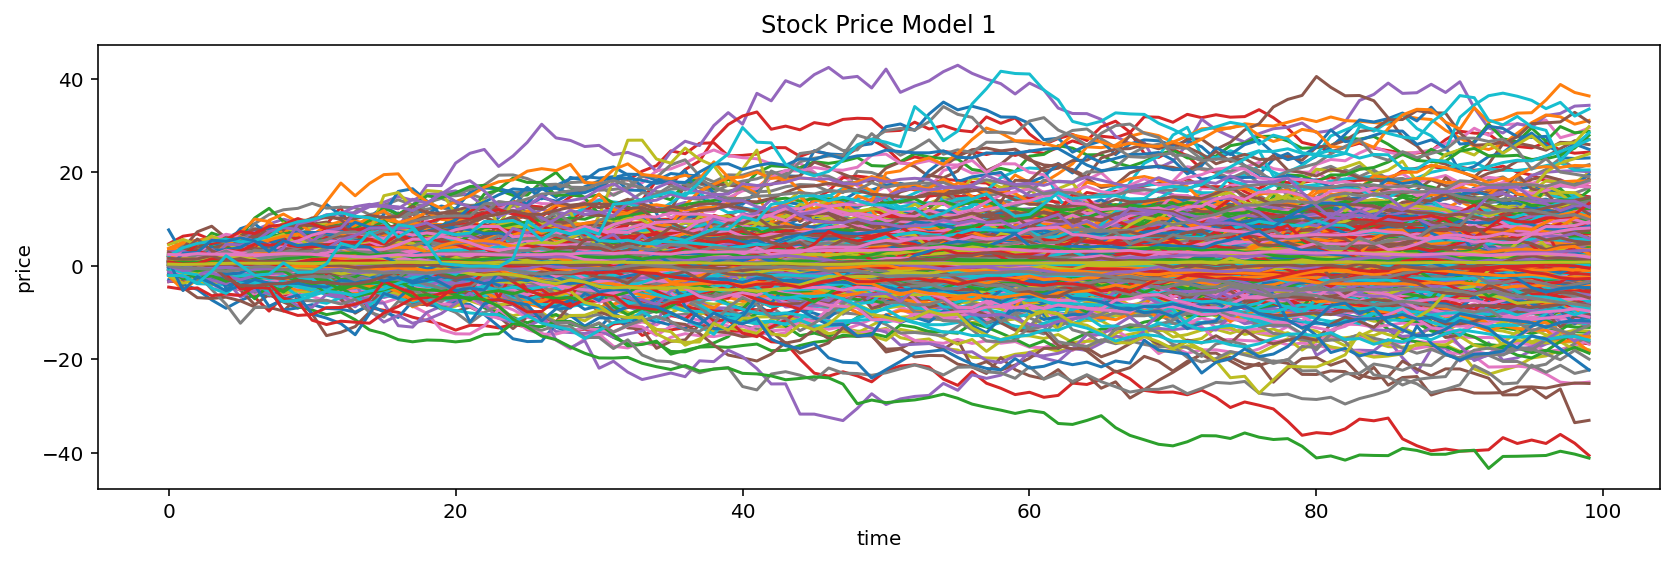

In [4]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
idata.prior.price.sel(chain=0).plot(x='time', hue='draw', add_legend=False, ax=ax)
ax.set_title('Stock Price Model 1')
plt.show()

### Model refinement 1: Work with returns
Those of you familiar with finance might see that what we call "epsilon" is actually a *return*. Prices evolve multiplicatively with returns, so that:

$$ P_t = (1 + r_t) P_{t-1} $$

Let's adjust the model to compute prices this way instead. We can still play the same substitution game starting from $P_0$:

$$
\begin{align}
P_1 & = (1 + r_1)P_0 \\
P_2 & = (1 + r_2)P_1 \\
P_3 & = (1 + r_3)P_2 
\end{align}
$$

But we have an equation for $P_1$, so plug it into the equation for $P_2$ :

$$
\begin{align}
P_1 & = (1 + r_1)P_0 \\
P_2 & = (1 + r_2)(1 + r_1)P_0 \\
P_3 & = (1 + r_3)P_2 
\end{align}
$$

And plug in the equation for $P_2$ into $P_3$:

$$
\begin{align}
P_1 & = (1 + r_1)P_0 \\
P_2 & = (1 + r_2)(1 + r_1)P_0 \\
P_3 & = (1 + r_3)(1 + r_2)(1 + r_1)P_0 
\end{align}
$$

So we come up with:

$$ P_t = \left ( \prod_{s=1}^t (1 + r_s) \right ) P_0 $$

In [5]:
with pm.Model(coords={'time':range(T)}) as stock_model:
    # Convert the math formulas to code!
    P0 = pm.HalfNormal('P0', 1)
    sigma = pm.HalfNormal('sigma', 1)

    def random_walk_2(P0, sigma, size=None):
        returns = pm.Normal.dist(0, sigma, size=size)
        return P0 * (1 + returns).cumprod()

    price = pm.CustomDist('price', P0, sigma, dist=random_walk_2, dims=['time'])

    # Run the generative model
    idata = pm.sample_prior_predictive(random_seed=rng)

Sampling: [P0, price, sigma]


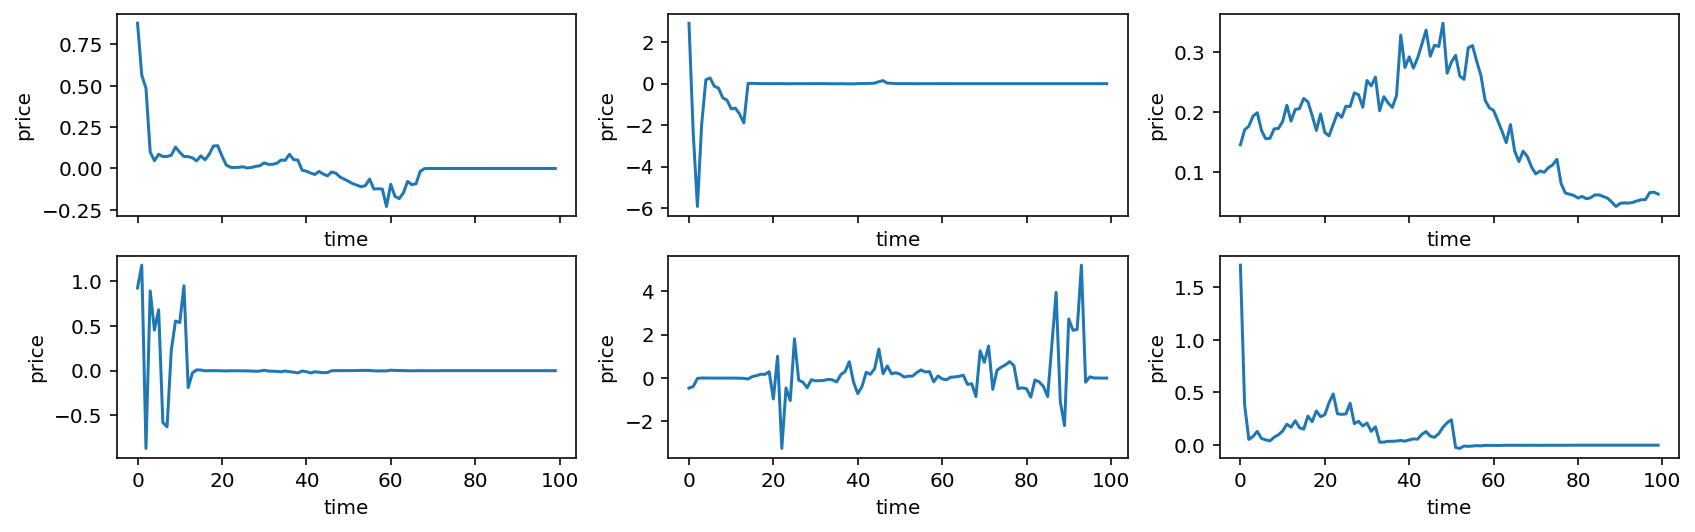

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(14, 4), dpi=144, sharex=True, sharey=False)
for i, axis in enumerate(fig.axes):
    idata.prior.price.sel(chain=0, draw=i).plot(x='time', ax=axis)
    axis.set_title('')
plt.show()

### Model refinement 2: Incorporate prior knowledge

This is better, but still not perfect. We have these huge jumps, which occur because the standard deviation on returns is much too large. Average annual US stock returns have been something like 4-8% on average over the last 100 years. Let's choose $\sigma$ so that returns fall between -8% and 8%, which implies $\sigma = 0.04$, because 98% of the probabilitiy mass of a normal is within 2-$\sigma$. 

Our sigma is unknown, but we'd like it to be "centered" around 0.04. But a half-normal can't be centered around anything but zero! We should change priors. A [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) is more flexible, and allows all kinds of shapes, while still being restricted to positive values. The Gamma is parameterized by two parameters $\alpha$ and $\beta$, that are not very easy to interpret.

One great way to choose priors in this situation is to use a **maximum entropy criteria**. "Entropy" (in the information theoritic sense -- so [Shannon Entropy](https://en.wikipedia.org/wiki/Shannon_entropy)) measures how flat a distribution is. That is, higher entropy --> more uncertainty --> flatter distribution.

`preliz` is a package for explorign priors. For a given family of distributions (in our case, the Gamma family), you can ask which Gamma distribution has the highest entropy, *and* a certain amount of probability density in a requested range.

So we can ask preliz, "give me the most uncertain Gamma that has 94% mass between 3% and 6%". It turns out to be $\text{Gamma}(2.97, 10.1)$. Who knew! This can be our new prior on $\sigma$.

(Gamma(alpha=2.97, beta=10.2), <Axes: >)

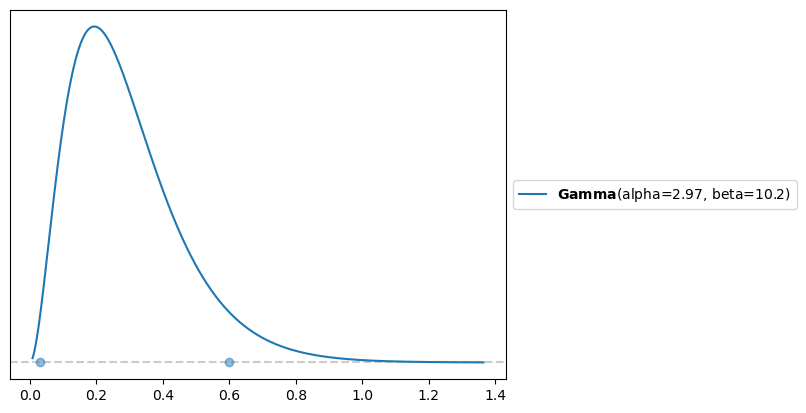

In [7]:
import preliz as pz
pz.maxent(pz.Gamma(), 0.03, 0.6)

In [8]:
with pm.Model(coords={'time':range(T)}) as stock_model:
    # Convert the math formulas to code!
    P0 = pm.HalfNormal('P0', 1)
    sigma = pm.Gamma('sigma', alpha=2.97, beta=10.2)

    def random_walk_2(P0, sigma, size=None):
        returns = pm.Normal.dist(0, sigma, size=size)
        return P0 * (1 + returns).cumprod()

    price = pm.CustomDist('price', P0, sigma, dist=random_walk_2, dims=['time'])

    # Run the generative model
    idata = pm.sample_prior_predictive(random_seed=rng)

Sampling: [P0, price, sigma]


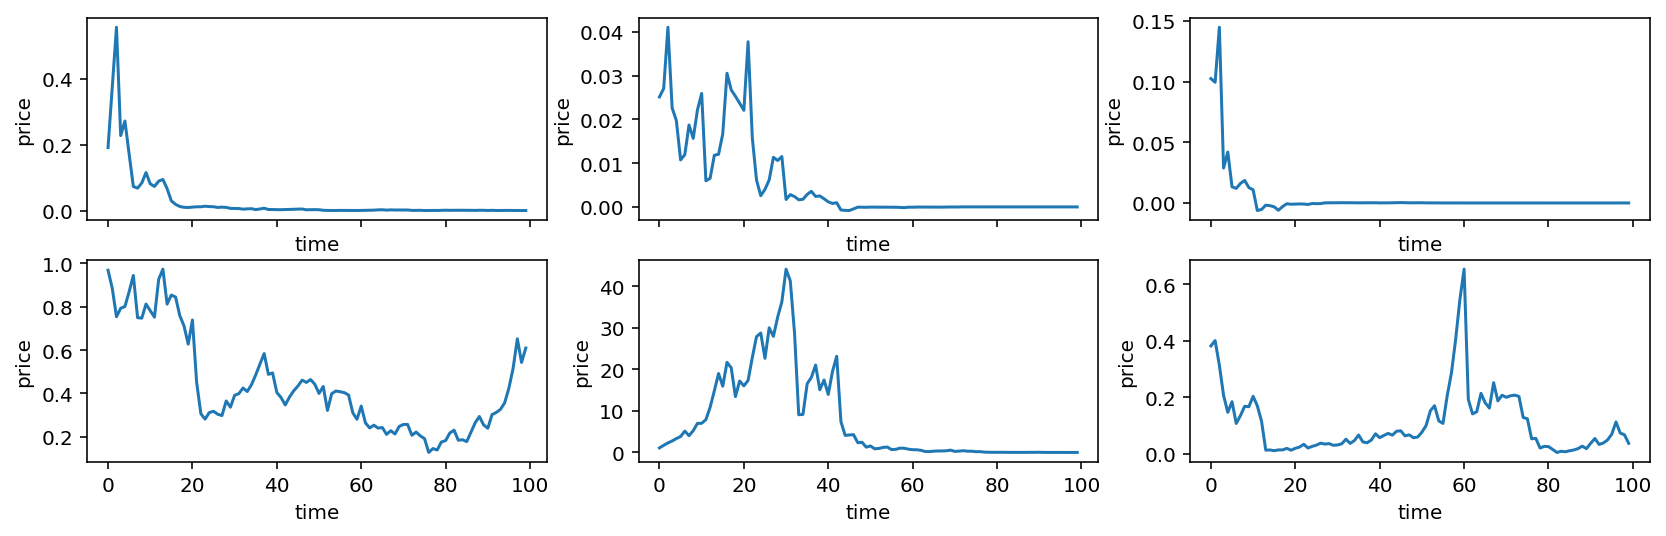

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(14, 4), dpi=144, sharex=True, sharey=False)
for i, axis in enumerate(fig.axes):
    idata.prior.price.sel(chain=0, draw=i).plot(x='time', ax=axis)
    axis.set_title('')
plt.show()

### Final refinement: Returns can't be more than -100%

This is starting to look reasonable, but we still have a problem with these huge price swings. Actually what we are seeing is that we got a draw from the returns distribution of greater than -1, which implies the stock dropped in price by more than 100%! This is clearly impossible.

The most natural way to fix this is to use a *truncated* distribution. Instead of drawing freely from a normal, we will draw from a normal with a minimum value of -1. We can use preliz to visualize the difference:

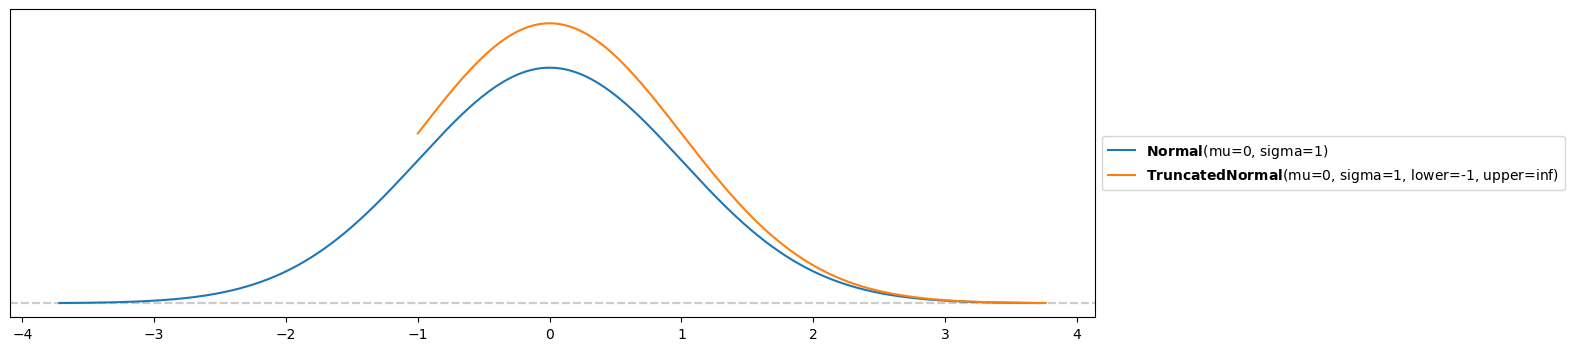

In [10]:
fig, ax = plt.subplots(figsize=(14, 4))
pz.Normal(0, 1).plot_pdf(ax=ax)
pz.TruncatedNormal(0, 1, -1, np.inf).plot_pdf(ax=ax)
plt.show()

In [11]:
with pm.Model(coords={'time':range(T)}) as stock_model:
    # Convert the math formulas to code!
    P0 = pm.HalfNormal('P0', 1)
    sigma = pm.Gamma('sigma', alpha=2.97, beta=10.2)

    def random_walk_2(P0, sigma, size=None):
        # I'll actually use a lower bound slightly larger than -1, so that trajectories don't get stuck at 0 forever
        returns = pm.TruncatedNormal.dist(0, sigma, lower=-0.9999, upper=np.inf, size=size)
        return P0 * (1 + returns).cumprod()

    price = pm.CustomDist('price', P0, sigma, dist=random_walk_2, dims=['time'])

    # Run the generative model
    idata = pm.sample_prior_predictive(random_seed=rng)

Sampling: [P0, price, sigma]


I hope everyone agrees that these finally look like reasonable stock prices!

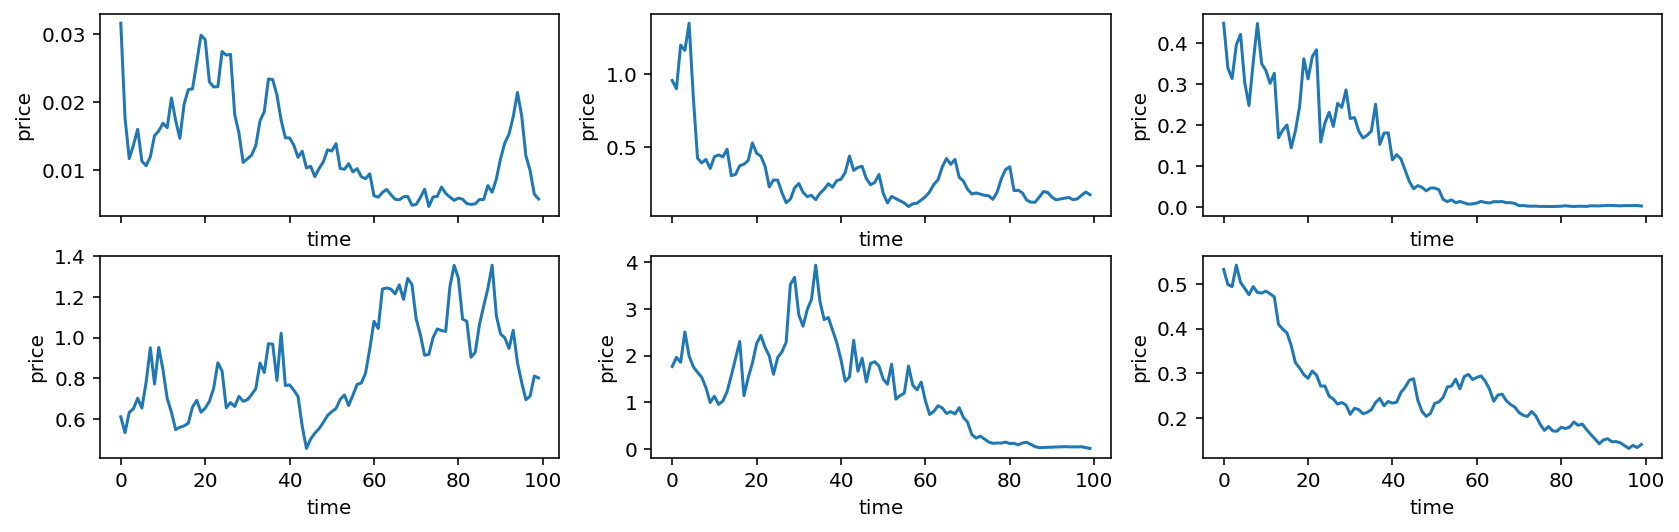

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(14, 4), dpi=144, sharex=True, sharey=False)
for i, axis in enumerate(fig.axes):
    idata.prior.price.sel(chain=0, draw=i).plot(x='time', ax=axis)
    axis.set_title('')
plt.show()